<a href="https://colab.research.google.com/github/skywalker0803r/crypto/blob/main/%E5%9D%87%E7%B7%9A%E7%AD%96%E7%95%A5%E7%B5%90%E5%90%88%E5%BC%B7%E5%8C%96%E5%AD%B8%E7%BF%92%E5%84%AA%E5%8C%96%E4%BA%A4%E6%98%93%E6%A9%9F%E5%99%A8%E4%BA%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [255]:
!pip install finlab_crypto
!pip install stable-baselines3

In [256]:
from binance.client import Client
import numpy as np
import finlab_crypto
from finlab_crypto import Strategy
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import random
import gym
from gym import spaces
from stable_baselines3.common.env_checker import check_env
import warnings 
warnings.filterwarnings('ignore')

# config

In [257]:
pairs = ['BTCUSDT']
freq = '4h'
api_key = '7P3fkeGPMWI1Cxfaje9Kdds1E3B0BHL8gL8Q8QH6pSvo3OuctGZroiyABMyLdTUs'
api_secret = 'UHVvoIowzhnTdhtjPX7VWkMdnf6M4SmMfAO4qQ7X9GHhQQ3Vha9FLEUxls02BGAe'
nbars = 10000

# Optimization get n1n2

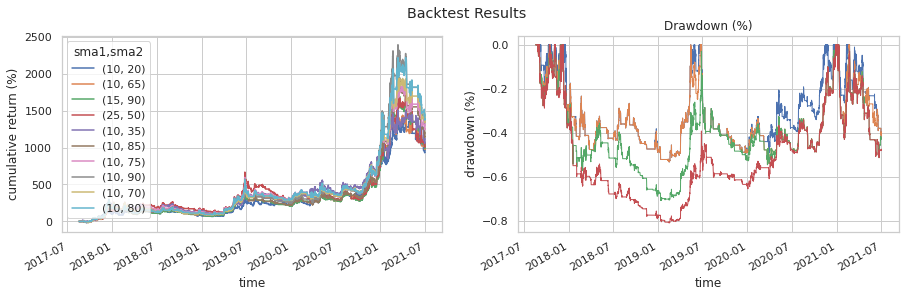

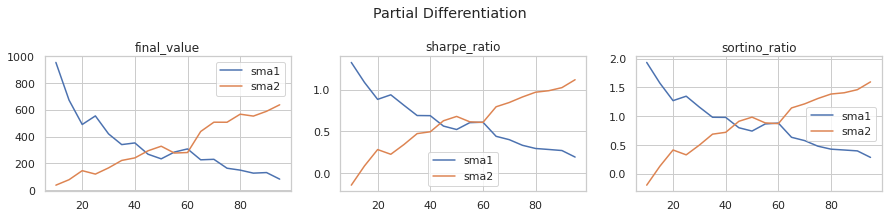

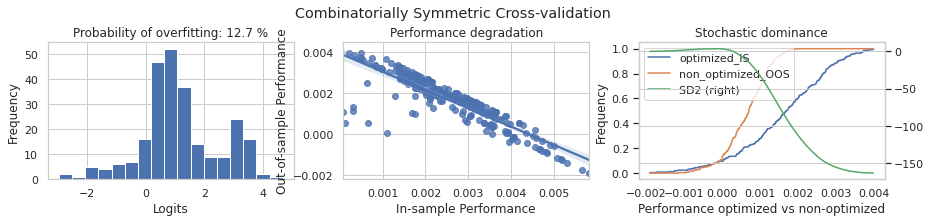

Output()

In [258]:
n1n2 = {}
info = {}
def Optimization(pair,freq):
  # get data
  ohlcv = finlab_crypto.crawler.get_nbars_binance(
      symbol=pair,
      interval=freq,
      nbars=nbars,
      client=Client(api_key, api_secret)
      )
  
  # Strategy
  @Strategy(sma1=20, sma2=60)
  def sma_strategy(ohlcv):
    close = ohlcv.close
    sma1 = close.rolling(sma_strategy.sma1).mean()
    sma2 = close.rolling(sma_strategy.sma2).mean()
    entries = (sma1 > sma2) & (sma1.shift() < sma2.shift())
    exits = (sma1 < sma2) & (sma1.shift() > sma2.shift())
    figures = {'overlaps': {'sma1': sma1,'sma1': sma2}}
    return entries, exits, figures
  
  # variables
  variables = {
      'sma1': np.arange(10, 100, 5), 
      'sma2': np.arange(10, 100, 5),
      }

  return sma_strategy.backtest(ohlcv, variables=variables, freq=freq ,plot=True)

infos = {}
for pair in pairs:
  infos[pair] = Optimization(pair,freq)

In [259]:
'''
(10019,)
timestamp
2020-05-10 00:00:00+00:00    False
2020-05-10 01:00:00+00:00    False
2020-05-10 02:00:00+00:00    False
2020-05-10 03:00:00+00:00    False
2020-05-10 04:00:00+00:00    False
                             ...  
2021-07-01 21:00:00+00:00    False
2021-07-01 22:00:00+00:00    False
2021-07-01 23:00:00+00:00    False
2021-07-02 00:00:00+00:00    False
2021-07-02 01:00:00+00:00    False
Name: close, Length: 10019, dtype: bool
'''

'\n(10019,)\ntimestamp\n2020-05-10 00:00:00+00:00    False\n2020-05-10 01:00:00+00:00    False\n2020-05-10 02:00:00+00:00    False\n2020-05-10 03:00:00+00:00    False\n2020-05-10 04:00:00+00:00    False\n                             ...  \n2021-07-01 21:00:00+00:00    False\n2021-07-01 22:00:00+00:00    False\n2021-07-01 23:00:00+00:00    False\n2021-07-02 00:00:00+00:00    False\n2021-07-02 01:00:00+00:00    False\nName: close, Length: 10019, dtype: bool\n'

In [260]:
n1n2 = portfolio.total_profit().reset_index().sort_values(by=0,ascending=False).head(10)
n1n2

,sma1,sma2,0
105,35,85,180.829609
106,35,90,175.982216
122,40,80,173.547562
33,15,85,168.274546
15,10,85,162.072818
88,30,90,157.964636
14,10,80,152.746155
17,10,95,149.285557
123,40,85,149.014063
87,30,85,148.361216


# make feature by n1n2

In [268]:
def ohlcv2sma(ohlcv,n=5):
  sma = ohlcv.close.rolling(n).mean()
  return sma
def minmaxtransform(x):
  return (x-x.min()) / (x.max()-x.min())

def ohlcv2feature(ohlcv,n1n2):
  nset = sorted(set(n1n2['sma1'])|set(n1n2['sma2']))
  feature = pd.DataFrame()
  for n in nset:
    feature[n] = ohlcv2sma(ohlcv,n)
  feature = minmaxtransform(feature)
  feature = feature.fillna(value=-1)
  return feature

In [269]:
# get data
ohlcv = finlab_crypto.crawler.get_nbars_binance(
    symbol=pair,
    interval=freq,
    nbars=nbars,
    client=Client(api_key, api_secret)
    )

total_len = len(ohlcv)
sp = int(total_len/2)
train_df = ohlcv.iloc[:sp,:]
test_df = ohlcv.iloc[sp:,:]

In [270]:
train_df

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,,
2017-08-17 04:00:00+00:00,1.502942e+12,4261.48,4349.99,4261.32,4349.99,82.088865,1.502957e+12,3.531943e+05,334.0,64.013727,2.756474e+05,8048.127886
2017-08-17 08:00:00+00:00,1.502957e+12,4333.32,4485.39,4333.32,4427.30,63.619882,1.502971e+12,2.825012e+05,248.0,58.787633,2.610541e+05,8020.698096
2017-08-17 12:00:00+00:00,1.502971e+12,4436.06,4485.39,4333.42,4352.34,174.562001,1.502986e+12,7.742388e+05,858.0,125.184133,5.554198e+05,8133.190658
2017-08-17 16:00:00+00:00,1.502986e+12,4352.33,4354.84,4200.74,4325.23,225.109716,1.503000e+12,9.652911e+05,986.0,165.036363,7.078082e+05,8425.112852
2017-08-17 20:00:00+00:00,1.503000e+12,4307.56,4369.69,4258.56,4285.08,249.769913,1.503014e+12,1.079545e+06,1001.0,203.226685,8.782870e+05,8733.911395
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-25 20:00:00+00:00,1.564085e+12,9857.21,9949.99,9798.89,9879.87,4221.586793,1.564099e+12,4.167489e+07,47577.0,2231.284823,2.202951e+07,0.000000
2019-07-26 00:00:00+00:00,1.564099e+12,9882.15,9882.15,9637.00,9697.00,7912.265527,1.564114e+12,7.680985e+07,68103.0,3940.869872,3.825195e+07,0.000000
2019-07-26 04:00:00+00:00,1.564114e+12,9694.63,9789.82,9657.00,9764.36,3499.994913,1.564128e+12,3.403646e+07,45115.0,1875.946346,1.823870e+07,0.000000


In [271]:
test_df

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,,
2019-07-26 16:00:00+00:00,1.564157e+12,9794.01,9889.98,9737.16,9839.00,4431.858952,1.564171e+12,4.345563e+07,52874.0,2307.457762,2.263349e+07,0.0
2019-07-26 20:00:00+00:00,1.564171e+12,9838.98,9860.00,9738.00,9824.00,3293.586932,1.564186e+12,3.231489e+07,38828.0,1576.379383,1.546734e+07,0.0
2019-07-27 00:00:00+00:00,1.564186e+12,9824.00,10188.66,9815.00,10103.00,10046.036243,1.564200e+12,1.013897e+08,81239.0,5423.382618,5.470431e+07,0.0
2019-07-27 04:00:00+00:00,1.564200e+12,10103.02,10118.55,10025.16,10055.33,3131.486206,1.564214e+12,3.153085e+07,37824.0,1709.462042,1.721349e+07,0.0
2019-07-27 08:00:00+00:00,1.564214e+12,10057.32,10088.00,9440.00,9525.81,13484.420134,1.564229e+12,1.300033e+08,108611.0,5830.528514,5.618699e+07,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01 08:00:00+00:00,1.625126e+12,33350.00,33749.00,33001.00,33717.52,13370.624600,1.625141e+12,4.461441e+08,229754.0,6615.240407,2.207801e+08,0.0
2021-07-01 12:00:00+00:00,1.625141e+12,33717.52,33917.93,33055.00,33432.54,13280.172682,1.625155e+12,4.445668e+08,217875.0,6682.354374,2.237390e+08,0.0
2021-07-01 16:00:00+00:00,1.625155e+12,33432.54,33654.49,32711.00,33091.48,12799.477033,1.625170e+12,4.252109e+08,208496.0,6425.592669,2.135177e+08,0.0


# convert ohlcv 2 feature(state)

In [272]:
train_state = ohlcv2feature(train_df,n1n2)
test_state = ohlcv2feature(test_df,n1n2)

In [273]:
train_state

,10,15,30,35,40,80,85,90,95
timestamp,,,,,,,,,
2017-08-17 04:00:00+00:00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2017-08-17 08:00:00+00:00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2017-08-17 12:00:00+00:00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2017-08-17 16:00:00+00:00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2017-08-17 20:00:00+00:00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...
2019-07-25 20:00:00+00:00,0.420988,0.422729,0.456802,0.468351,0.475351,0.522025,0.528916,0.538098,0.552750
2019-07-26 00:00:00+00:00,0.420833,0.421732,0.454850,0.466680,0.474347,0.520249,0.527453,0.536396,0.550168
2019-07-26 04:00:00+00:00,0.419904,0.420102,0.453033,0.465117,0.473227,0.518379,0.526188,0.534849,0.547552


In [274]:
test_state

,10,15,30,35,40,80,85,90,95
timestamp,,,,,,,,,
2019-07-26 16:00:00+00:00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2019-07-26 20:00:00+00:00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2019-07-27 00:00:00+00:00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2019-07-27 04:00:00+00:00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2019-07-27 08:00:00+00:00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...
2021-07-01 08:00:00+00:00,0.506786,0.512817,0.508226,0.504248,0.506772,0.521621,0.527306,0.531919,0.537117
2021-07-01 12:00:00+00:00,0.502531,0.511503,0.509341,0.504858,0.506227,0.520633,0.526061,0.530817,0.535841
2021-07-01 16:00:00+00:00,0.499050,0.509484,0.510228,0.505617,0.505359,0.519542,0.524772,0.529665,0.534463


# Visualization states

In [279]:
def Visualization_states(df):
  days = 15
  Xs = []
  for i in tqdm(range(0,len(df)-days,1)):
    Xs.append(np.array(df.iloc[i:i+days,:]))
  Xs = np.array(Xs)
  %matplotlib inline
  plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace =0, hspace =0.3)
  j = 1
  for i in range(100,100+9):
    plt.subplot(330 + (j))
    plt.imshow(Xs[i])
    j +=1
  plt.show()
  return Xs

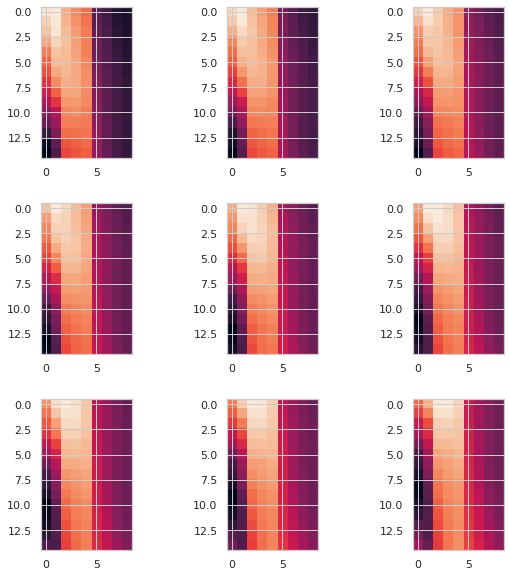

(4221, 15, 9)

In [280]:
Xs = Visualization_states(train_state)
Xs.shape

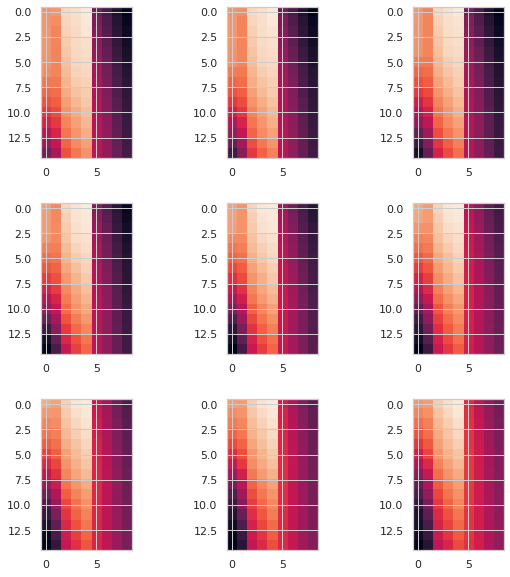

In [281]:
Xs = Visualization_states(test_state)

In [282]:
Xs.shape

(4222, 15, 9)

# TradingEnv

In [283]:
class TradingEnv(gym.Env):
  def __init__(self,df,n1n2):
    super(TradingEnv, self).__init__()
    self.df = df
    self.state_sequence = ohlcv2feature(self.df,n1n2)
    assert len(self.df) == len(self.state_sequence)
    self.INITIAL_ACCOUNT_BALANCE = 1000000
    self.time_length = 6*7 #(6*4=24h 24h*7 = 1week)
    self.features_dim = 9
    self.action_space = spaces.Discrete(3)
    self.observation_space = spaces.Box(low=0,high=1,shape=(1,self.time_length,self.features_dim),dtype=np.float32)
    
  def _next_observation(self):
    state = self.state_sequence.iloc[self.current_step:self.current_step+self.time_length,:]
    return np.array(state).reshape(1,self.time_length,self.features_dim).astype(np.float32)
  
  def reset(self):
    self.balance = self.INITIAL_ACCOUNT_BALANCE
    self.net_worth = self.INITIAL_ACCOUNT_BALANCE
    self.prev_net_worth = self.INITIAL_ACCOUNT_BALANCE
    self.shares_held = 0
    self.current_step = random.randint(0,len(self.df)-self.time_length)
    return self._next_observation()
  
  def render(self):
    profit = self.net_worth - self.INITIAL_ACCOUNT_BALANCE
    print(f'Step: {self.current_step}')
    print(f'Profit: {profit}')
  
  def step(self, action):
    self._take_action(action) # update net_worth
    self.current_step += 1
    if self.current_step > len(self.df) - self.time_length:
      self.current_step = 0
    reward = self.net_worth - self.prev_net_worth
    self.prev_net_worth = self.net_worth # update prev_net_worth
    done = self.net_worth <= 0
    obs = self._next_observation()
    return obs, reward, bool(done), {}
  
  def _take_action(self, action):
    current_price = random.uniform(self.df.iloc[self.current_step]['open'], self.df.iloc[self.current_step]['close'])
    if action == 0:
      shares_bought = self.balance / current_price # buy btc
      self.balance -= shares_bought * current_price # update usdt
      self.shares_held += shares_bought # update btc
      self.net_worth = self.balance + self.shares_held * current_price # update net_worth(total asset)
    if action == 1:
      shares_sold = self.shares_held # sell btc
      self.balance += shares_sold * current_price # update usdt
      self.shares_held -= shares_sold # update btc
      self.net_worth = self.balance + self.shares_held * current_price # update net_worth(total asset)
    if action == 2:
      pass # hold

# train

In [301]:
env = TradingEnv(train_df,n1n2)

In [302]:
check_env(env)

In [303]:
import gym
import torch as th
import torch.nn as nn

from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor


class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout(0.25),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(
            nn.Linear(n_flatten, features_dim),
            )

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128),
)

model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------------
| time/                   |             |
|    fps                  | 624         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.080837265 |
|    clip_fraction        | 0.396       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.999      |
|    explained_variance   | 0.00797     |
|    learning_rate        | 0.0003      |
|    loss                 | 2.66e+09    |
|    n_updates            | 30          |
|    policy_gradient_loss | 0.0538      |
|    value_loss           | 4.77e+09    |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 185       |
|    iterations           | 2 

# evaluate

In [304]:
def evaluate(n=5,df=None):
  for j in range(n):
    env = TradingEnv(df,n1n2)
    obs = env.reset()
    frames = []
    total_reward = 0
    for i in tqdm(range(1000)):
      action, _states = model.predict(obs)
      obs, rewards, dones, info = env.step(action)
      total_reward += rewards
      frames.append(total_reward)
    plt.plot(pd.Series(frames).rolling(30).mean(),label=str(j))
  plt.legend()
  plt.show()

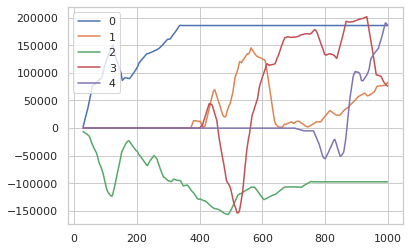

In [305]:
evaluate(n=5,df=train_df)

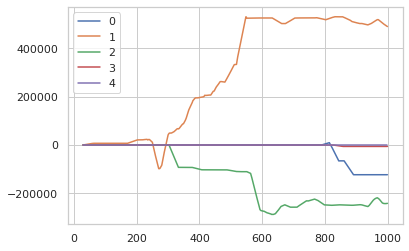

In [306]:
evaluate(n=5,df=test_df)

In [311]:
# Strategy
@Strategy()
def RL_sma_strategy(ohlcv):
  time_length = 6*7
  predicts = []
  predicts.extend([2 for _ in range(time_length)]) #0,1,2,buy,sell,hold
  states = ohlcv2feature(ohlcv,n1n2).values
  for i in tqdm(range(0,len(ohlcv)-time_length,1)):
    y = model.predict(states[i:i+time_length].reshape(1,time_length,9))[0]
    predicts.append(y)
  predicts = pd.Series(predicts,index=ohlcv.index)
  entries = (predicts == 0)
  exits = (predicts == 1)
  figures = {}
  return entries, exits, figures

In [312]:
RL_sma_strategy.backtest(train_df,freq=freq ,plot=True)

In [313]:
RL_sma_strategy.backtest(test_df,freq=freq ,plot=True)